RFM segmentation is a customer segmentation technique often used in  marketing campaign optimization to divide the target customer base  according to three  behaviorial patterns i.e. Recency(how recent the latest purchase was made), Frequency(how frequently purchases are made), and Monetary Value(amount spent by a customer). Market basket analysis on the other hand is a type of association analysis method (which we saw in the other python file) based upon the premise that if a customer buys a certain group of items, he/she is more likely to another group of items. In this project we would first use machine learning algorithm called kmeans clustering to implement RFM segmentation. After that we would apply a market basket algorithm called apriori on a specific customer segment. This python machine learning code could be implemented in SAP Analytics Cloud for visualization and analysis for the business users. To do so however we have to access the HANA database and do our data manipulation on HANA using pthon. At the end of the file I included the codes one has to add to implment this project on his/her specific HANA database.https://help.sap.com/doc/saphelp_nw75/7.5.5/en-US/00/f0895360b93d58e10000000a174cb4/frameset.htm

In [ ]:
#Importing necessary libraries for data processing, machine learning and visualiation


import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
import plotly.offline as pyoff
import plotly.graph_objs as go
import seaborn as sns
#from IPython.core.display_functions import display
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import os
import warnings
from tqdm.autonotebook import get_ipython
from datetime import timedelta
from datetime import datetime
warnings.filterwarnings("ignore")




In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
#reading datafile and showing output for first few records
df = pd.read_excel(r"/content/drive/MyDrive/Market Basket Analysis-colab/Final Versions/Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# checking and fixing 'empty record'  issues

df.isnull().sum()
df = df.dropna(subset=['CustomerID'])
df.isnull().sum().sum()

0

In [ ]:
# checking and  fixing 'duplicate' data issues

df.duplicated().sum()
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
#data overview and statistics after initial cleaning

df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
#fixing invoice date format for further sales order analysis
convert_dict = {'InvoiceDate': str}
df = df.astype(convert_dict)
print(df.dtypes)



InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['order_date'] = [d.date() for d in df['InvoiceDate']]
df['order_time'] = [d.time() for d in df['InvoiceDate']]
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,order_time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


In [ ]:
#to see the datatype of a specific column(order_time) we could check couple of individual elements of that column using the code ::
#print(type(df['order_time'].iloc[5]))

In [ ]:

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,order_time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


In [ ]:
# New Total Sum Column
df['TotalSum'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,order_time,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34


In [ ]:
#Printing minimum an maximum invoice date(min()-With a single iterable argument, return its smallest item)
print('Min Invoice Date:', df.order_date.min(), 'max Invoice Date:',
      df.order_date.max())

Min Invoice Date: 2010-12-01 max Invoice Date: 2011-12-09


In [ ]:
# The last day of purchase  is 09 DEC, 2011. We will create a snapshot_date one day after the last day which would then be
# 10 DEC,2011 . We will round the different days with snapshot_date.


In [ ]:
snapshot_date = df['order_date'].max() + dt.timedelta(days=1)
snapshot_date



datetime.date(2011, 12, 10)

"""For my testing purposes, omit during final version
rfm = df.groupby(['CustomerID']).agg({'order_date': lambda x: (
    snapshot_date - x.max()).days, 'InvoiceNo': 'count', 'TotalSum': 'sum'})
rfm.head()

In [ ]:
# Calculate RFM Metrics and show output w R F M values for each customer

rfm = df.groupby(['CustomerID']).agg({'order_date': lambda x: (
    snapshot_date - x.max()).days, 'InvoiceNo': 'count', 'TotalSum': 'sum'})
rfm.rename(columns={'order_date': 'Recency', 'InvoiceNo': 'Frequency',
           'TotalSum': 'MonetaryValue'}, inplace=True)
# Final RFM values
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


In [ ]:
# Building RFM Segments
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_quartiles = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_quartiles = pd.qcut(rfm['Frequency'], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'], q=4, labels=m_labels)

rfm = rfm.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)

# Build RFM Segment and RFM Score
def add_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

rfm['RFM_Segment'] = rfm.apply(add_rfm, axis=1)
#rfm['RFM_Segment_Category'] = rfm[['R', 'F', 'M']].sum(axis=1)



rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,114
12347.0,3,182,4310.00,4,4,4,444
12348.0,76,31,1797.24,2,2,4,224
12349.0,19,73,1757.55,3,3,4,334
12350.0,311,17,334.40,1,1,2,112
...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111
18281.0,181,7,80.82,1,1,1,111
18282.0,8,12,178.05,4,1,1,411


Above, built RFM (Recency, Frequency, Monetary) segments and calculating RFM scores for the dataset (defined label ranges for Recency, Frequency, and Monetary Value. Recency will have a reversed range (4 to 1), as lower recency scores correspond to more recent purchases)


RFM stands for Recency, Frequency, and Monetary Value. It is a popular marketing analysis tool that helps businesses identify and prioritize their customers based on their purchasing behavior. The goal of RFM analysis is to segment customers into different groups based on their transaction history, so that businesses can target their marketing efforts more effectively.

An RFM segment is a categorical label assigned to a customer based on their Recency, Frequency, and Monetary Value scores(basically rfm segment is the id based on rfm score meaning two different customer ids w same rfm score would have same rfm segment). In our example here the RFM segment is created by concatenating the individual R, F, and M scores as a string. For example, a customer with Recency score 4, Frequency score 2, and Monetary Value score 3 would have an RFM segment of '423'.

RFM segments can help businesses understand the characteristics of different customer groups, such as high-value customers, regular customers, or inactive customers. By analyzing these segments, businesses can tailor their marketing strategies, promotional offers, and communications to better suit each group's needs and preferences.

An RFM score is a numerical representation of a customer's overall transaction behavior, calculated as the sum of their individual Recency, Frequency, and Monetary Value scores.
The RFM score is a single metric that summarizes the customer's purchasing behavior, making it easier to rank and compare customers. A higher RFM score typically indicates a more valuable customer, as they have more recent purchases, frequent transactions, and higher spending. By analyzing RFM scores, businesses can identify their most valuable customers and allocate resources to retain and engage them more effectively.




In [ ]:
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

# Summary metrics per RFM Score

rfm.groupby('RFM_Segment').agg({'Recency': 'mean', 'Frequency': 'mean',

                              'MonetaryValue': ['mean', 'count']}).round(1)


Recency Frequency MonetaryValue      
               mean      mean          mean count
RFM_Segment                                      
111           261.2       8.2         157.4   381
112           256.8      10.4         392.4   109
113           240.9       8.8         961.3    24
114           251.3       6.7       17815.7    10
121           254.4      26.0         199.9   101
...             ...       ...           ...   ...
434             8.9      76.8        4361.8    81
441             9.0     113.3         289.2     3
442             9.5     133.8         541.9    14
443             8.9     184.1        1170.0    87
444             7.6     371.0        9393.2   443

[61 rows x 4 columns]

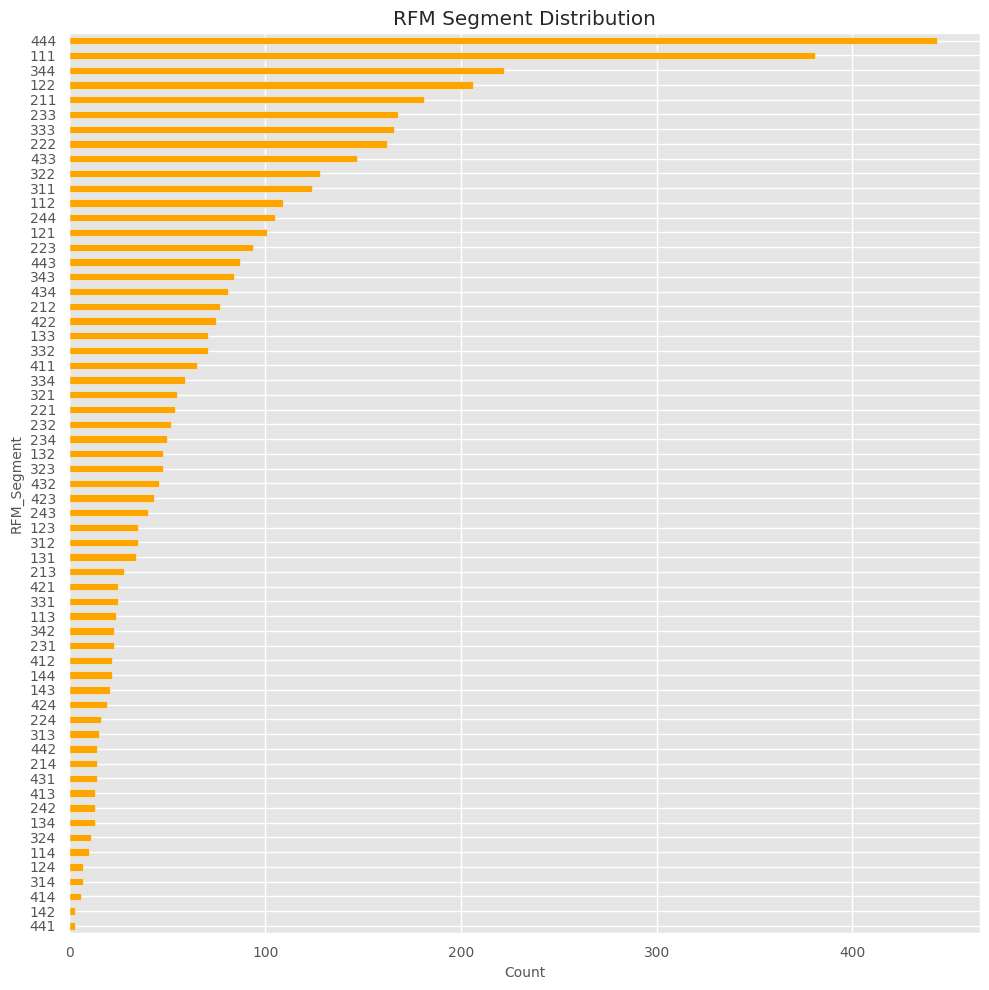

In [ ]:
# Plotting RFM_Segment vs count in descending order

# Calculate the value counts and sort by counts in descending order
rfm_value_counts = rfm['RFM_Segment'].value_counts().sort_values(ascending=False)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 10))
rfm_value_counts.plot(kind='barh', ax=ax, color="orange", fontsize=10)

# Set labels and title
ax.set_xlabel("Count", fontsize=10)
ax.set_ylabel("RFM_Segment", fontsize=10)
ax.set_title("RFM Segment Distribution")

# Invert the y-axis so that the highest count is at the top
ax.invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()


Above,  bar plot of the 'RFM_Score' frequency distribution

## K-means Clustering

In [ ]:
# Data Pre-Processing for K-means Clustering

rfm_k = rfm[['Recency', 'Frequency', 'MonetaryValue']]
print(rfm_k.describe())


           Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     93.059474    90.523744    2048.688081
std     100.012264   225.506968    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     306.482500
50%      51.000000    41.000000     668.570000
75%     142.750000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000


In [ ]:
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,114
12347.0,3,182,4310.00,4,4,4,444
12348.0,76,31,1797.24,2,2,4,224
12349.0,19,73,1757.55,3,3,4,334
12350.0,311,17,334.40,1,1,2,112
...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111
18281.0,181,7,80.82,1,1,1,111
18282.0,8,12,178.05,4,1,1,411


In [ ]:
#t
rfm_k

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


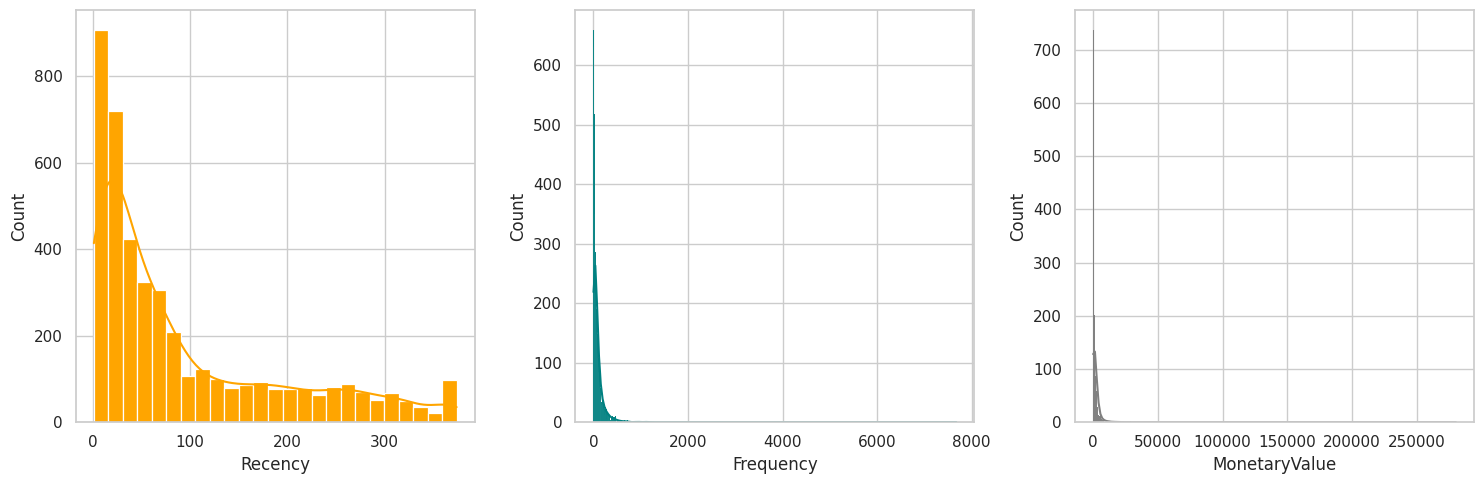

In [ ]:
# Plot the distribution of RFM_K values

# Set the style and context
sns.set_style("whitegrid")
sns.set_context("notebook")

# Plot the distribution of RFM_K values
f, ax = plt.subplots(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm.Recency, kde=True, color='orange',alpha=1, label='Recency')

plt.subplot(1, 3, 2)
sns.histplot(rfm.Frequency, kde=True, color='teal',alpha=1, label='Frequency')

plt.subplot(1, 3, 3)
sns.histplot(rfm.MonetaryValue, kde=True, color='grey',alpha=1, label='Monetary Value')

plt.tight_layout()

plt.show()



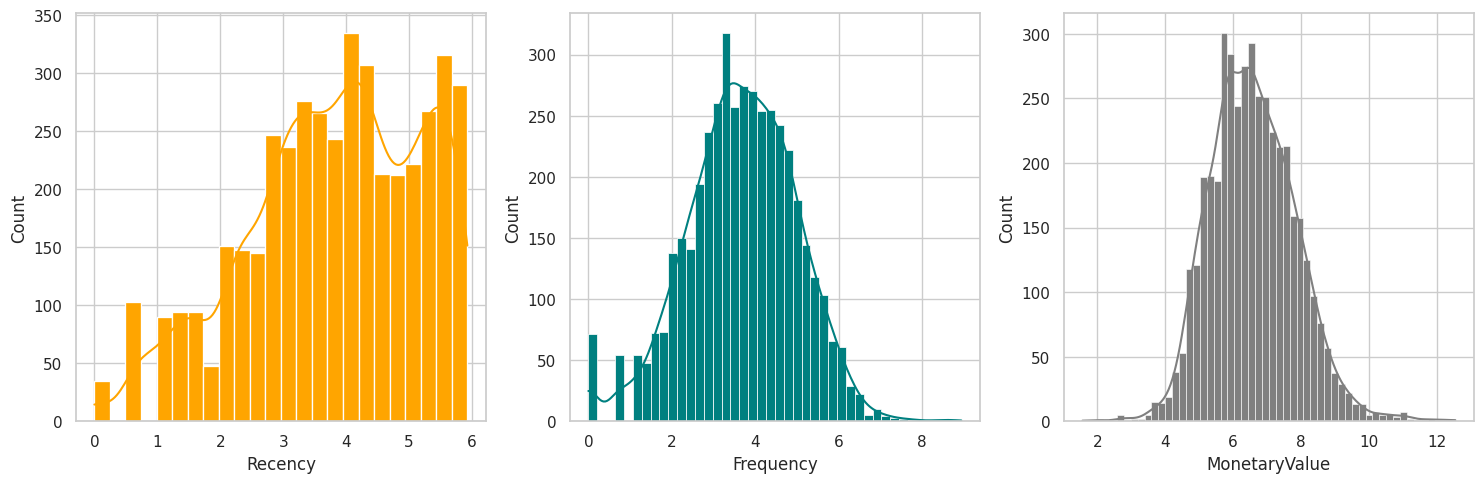

In [ ]:
# Add a small constant value (e.g., 1) to avoid issues with log transformation
rfm['MonetaryValue'] = rfm['MonetaryValue'] + 1

# Unskew the data with log transformation
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(
    np.log, axis=1).round(3)

# Set the style and context
sns.set_style("whitegrid")
sns.set_context("notebook")

# Plot the distribution of RFM values
f, ax = plt.subplots(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm_log.Recency, kde=True, color='orange',alpha=1,label='Recency')

plt.subplot(1, 3, 2)
sns.histplot(rfm_log.Frequency, kde=True, color='teal',alpha=1, label='Frequency')

plt.subplot(1, 3, 3)
sns.histplot(rfm_log.MonetaryValue, kde=True, color='grey',alpha=1, label='Monetary Value')

plt.tight_layout()

plt.show()



In [ ]:
# Implementation of K-Means Clustering
# Normalize the variables with StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

# Store it separately for clustering
rfm_normalized = scaler.transform(rfm_log)

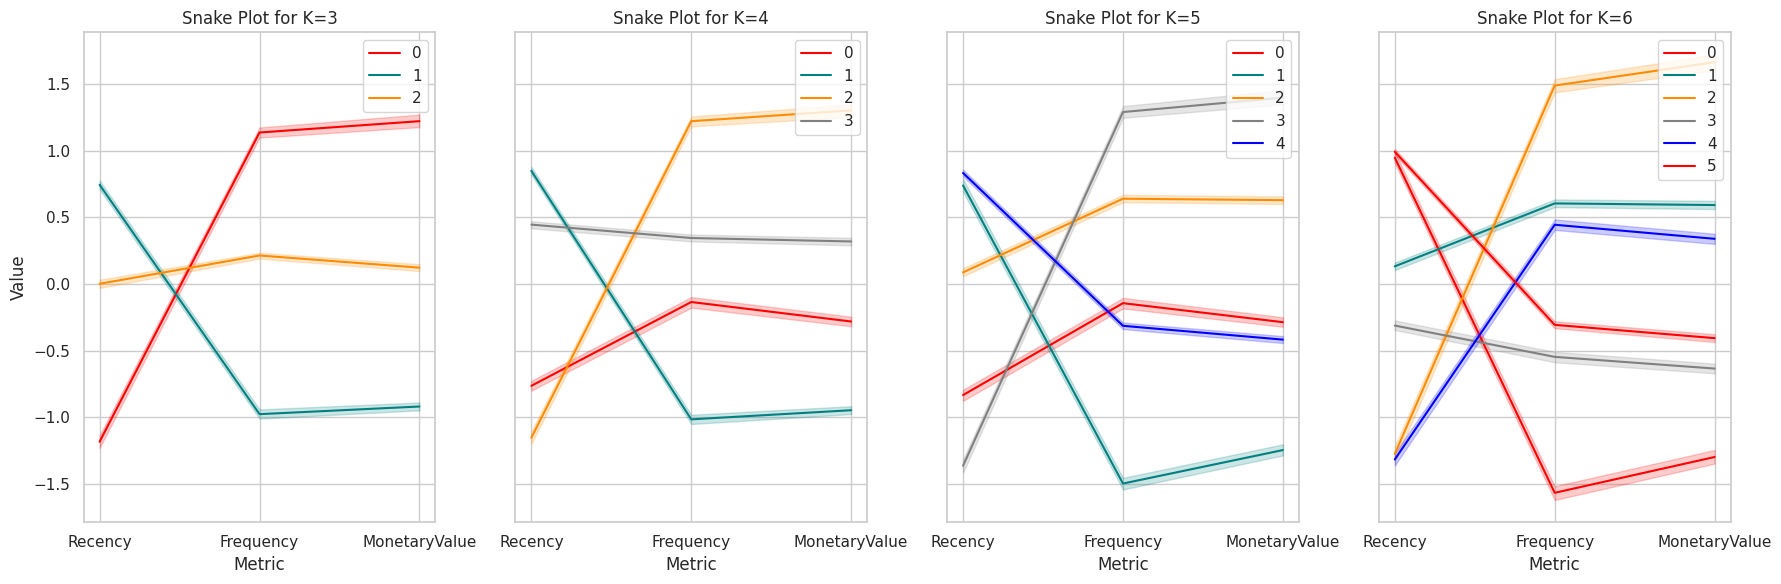

In [ ]:

# Create a DataFrame with normalized RFM values
rfm_normalized_df = pd.DataFrame(rfm_normalized, index=rfm.index, columns=['Recency', 'Frequency', 'MonetaryValue'])
rfm_normalized_df = rfm_normalized_df.reset_index()

# Create a function for KMeans clustering and snake plots
def create_kmeans_snake_plot(ax, k, rfm_normalized, rfm_normalized_df):
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state=42)
    kmeans.fit(rfm_normalized)
    cluster_labels = kmeans.labels_
    rfm_c = rfm_normalized_df.assign(Cluster=cluster_labels)

    # Melt the normalized dataset
    rfm_melt = pd.melt(rfm_c,
                       id_vars=['CustomerID', 'Cluster'],
                       value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                       var_name='Metric',
                       value_name='Value')

    # Define custom colors
    custom_colors = ['red', 'teal', 'darkorange', 'grey', 'blue']

    # Create the snake plot
    sns.lineplot(ax=ax, data=rfm_melt, x='Metric', y='Value', hue='Cluster', palette=custom_colors[:k], alpha=1)
    ax.set_title(f'Snake Plot for K={k}')
    ax.legend(loc='upper right')

# Create snake plots for K=3, K=4, and K=5

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)
for i, k in enumerate([3, 4, 5, 6]):
    create_kmeans_snake_plot(axes[i], k, rfm_normalized, rfm_normalized_df)

plt.tight_layout()
plt.show()





In [ ]:
# Clustering
kc = KMeans(n_clusters=4, random_state=1)
kc.fit(rfm_normalized)
# Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

# Assign cluster labels to the original DataFrame
rfm_k4 = rfm.assign(K_Cluster=cluster_labels)
rfm_k4

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,K_Cluster
CustomerID,,,,,,,,
12346.0,326,1,77184.60,1,1,4,114,0
12347.0,3,182,4311.00,4,4,4,444,1
12348.0,76,31,1798.24,2,2,4,224,0
12349.0,19,73,1758.55,3,3,4,334,1
12350.0,311,17,335.40,1,1,2,112,2
...,...,...,...,...,...,...,...,...
18280.0,278,10,181.60,1,1,1,111,2
18281.0,181,7,81.82,1,1,1,111,2
18282.0,8,12,179.05,4,1,1,411,3


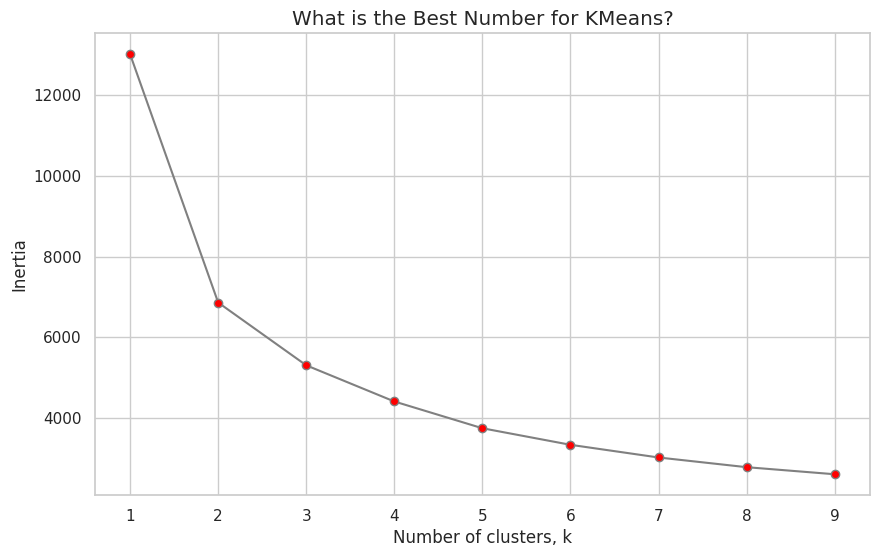

In [ ]:

# Choosing the optimal number of clusters by visualizing elbow method
ks = range(1, 10)
inertias = []

for k in ks:
    # Create KMeans clusters
    kc = KMeans(n_clusters=k, random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(10, 6))
plt.plot(ks, inertias, '-o', color='grey', markerfacecolor='red')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans?')
plt.show()


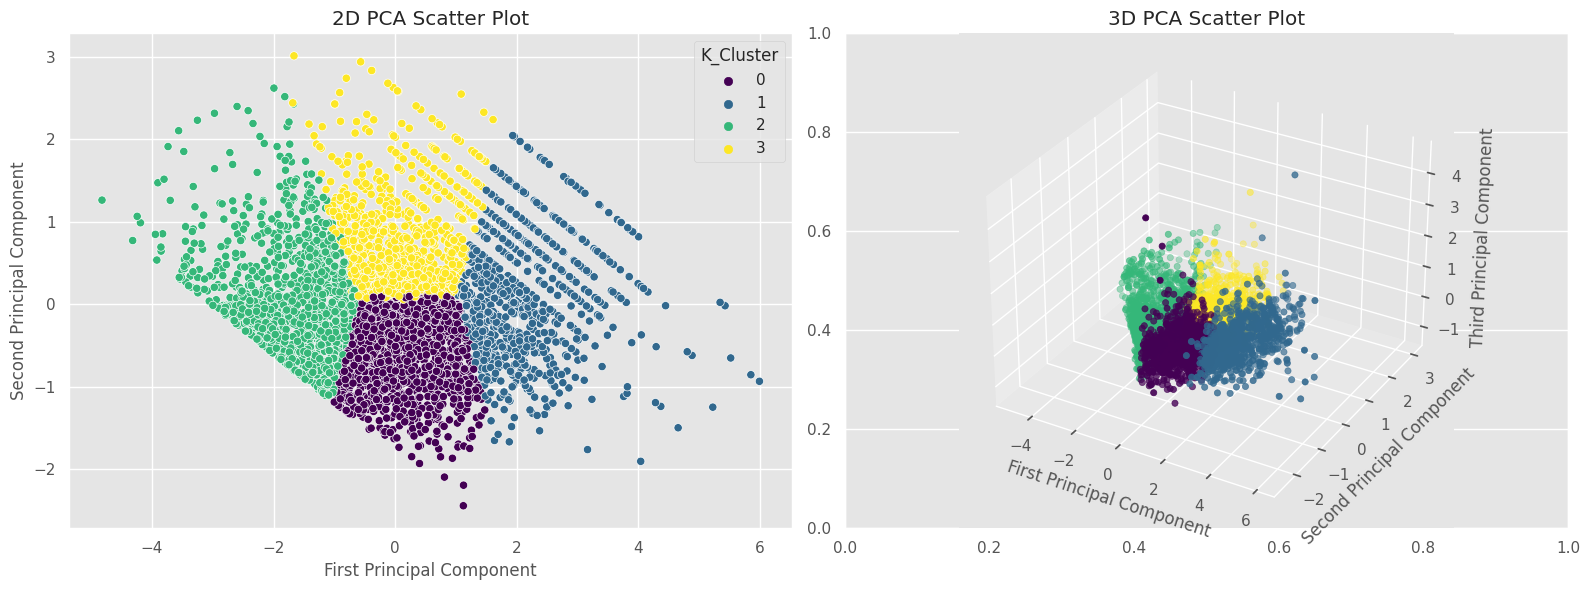

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA on the normalized data
pca2 = PCA(n_components=2)
pca_components2 = pca2.fit_transform(rfm_normalized)

# Perform PCA with 3 components
pca3 = PCA(n_components=3)
pca_components3 = pca3.fit_transform(rfm_normalized)

# Add the PCA components to the DataFrame
rfm_pca2 = rfm_k4.assign(x2=pca_components2[:, 0], y2=pca_components2[:, 1])
rfm_pca3 = rfm_k4.assign(x3=pca_components3[:, 0], y3=pca_components3[:, 1], z3=pca_components3[:, 2])

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Create the 2D PCA scatter plot
sns.scatterplot(data=rfm_pca2, x='x2', y='y2', hue='K_Cluster', palette='viridis', ax=ax1)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.set_title('2D PCA Scatter Plot')

# Create the 3D PCA scatter plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter3d = ax2.scatter(rfm_pca3['x3'], rfm_pca3['y3'], rfm_pca3['z3'], c=rfm_pca3['K_Cluster'], cmap='viridis')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.set_zlabel('Third Principal Component')
ax2.set_title('3D PCA Scatter Plot')

plt.tight_layout()
plt.show()

In [ ]:
# Create a dictionary to map the cluster labels to segment names
segment_names = {
    0: 'Segment_0',
    1: 'Segment_1',
    2: 'Segment_2',
    3: 'Segment_3'
}

# Replace the cluster labels with the segment names
rfm_k4['Segment'] = rfm_k4['K_Cluster'].replace(segment_names)

# Calculate average RFM values and sizes for each segment
rfm_k4_summary = rfm_k4.groupby(['Segment']).agg({
    'Recency': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'MonetaryValue': ['mean', 'min', 'max', 'count']
})

rfm_k4_summary

Recency            Frequency           MonetaryValue          \
                 mean min  max        mean min   max          mean     min   
Segment                                                                      
Segment_0  104.438111  22  374   76.201954   1   521   1457.789912  203.27   
Segment_1   13.931034   1  101  278.826437   3  7676   7060.202425  610.30   
Segment_2  182.450149   8  374   14.183036   1    74    284.081355    4.75   
Segment_3   20.210938   1   62   41.824777   1   201    644.195794   42.99   

                            
                 max count  
Segment                     
Segment_0   77184.60  1228  
Segment_1  280207.02   870  
Segment_2    4056.72  1344  
Segment_3    6978.04   896

In [ ]:
mdf = pd.merge(df,rfm_k4, on='CustomerID')
mdf

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,order_time,TotalSum,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,K_Cluster,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30,373,297,5392.21,1,4,4,144,0,Segment_0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,373,297,5392.21,1,4,4,144,0,Segment_0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00,373,297,5392.21,1,4,4,144,0,Segment_0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,373,297,5392.21,1,4,4,144,0,Segment_0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,373,297,5392.21,1,4,4,144,0,Segment_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392687,581578,22993,SET OF 4 PANTRY JELLY MOULDS,12,2011-12-09 12:16:00,1.25,12713.0,Germany,2011-12-09,12:16:00,15.00,1,38,849.55,4,2,3,423,3,Segment_3
392688,581578,22907,PACK OF 20 NAPKINS PANTRY DESIGN,12,2011-12-09 12:16:00,0.85,12713.0,Germany,2011-12-09,12:16:00,10.20,1,38,849.55,4,2,3,423,3,Segment_3
392689,581578,22908,PACK OF 20 NAPKINS RED APPLES,12,2011-12-09 12:16:00,0.85,12713.0,Germany,2011-12-09,12:16:00,10.20,1,38,849.55,4,2,3,423,3,Segment_3
392690,581578,23215,JINGLE BELL HEART ANTIQUE SILVER,12,2011-12-09 12:16:00,2.08,12713.0,Germany,2011-12-09,12:16:00,24.96,1,38,849.55,4,2,3,423,3,Segment_3


In [ ]:
CustomerSegment_0=mdf[mdf.Segment == 'Segment_0']
CustomerSegment_1=mdf[mdf.Segment == 'Segment_1']
CustomerSegment_2=mdf[mdf.Segment == 'Segment_2']
CustomerSegment_3=mdf[mdf.Segment == 'Segment_3']
CustomerSegment_0

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,order_time,TotalSum,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,K_Cluster,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30,373,297,5392.21,1,4,4,144,0,Segment_0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,373,297,5392.21,1,4,4,144,0,Segment_0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00,373,297,5392.21,1,4,4,144,0,Segment_0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,373,297,5392.21,1,4,4,144,0,Segment_0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34,373,297,5392.21,1,4,4,144,0,Segment_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384942,576076,22610,PENS ASSORTED FUNNY FACE,72,2011-11-13 16:18:00,0.19,14382.0,United Kingdom,2011-11-13,16:18:00,13.68,27,126,616.49,3,4,2,342,0,Segment_0
384943,576076,22608,PENS ASSORTED FUNKY JEWELED,72,2011-11-13 16:18:00,0.19,14382.0,United Kingdom,2011-11-13,16:18:00,13.68,27,126,616.49,3,4,2,342,0,Segment_0
384944,576076,22609,PENS ASSORTED SPACEBALL,72,2011-11-13 16:18:00,0.19,14382.0,United Kingdom,2011-11-13,16:18:00,13.68,27,126,616.49,3,4,2,342,0,Segment_0
384945,576076,20974,12 PENCILS SMALL TUBE SKULL,19,2011-11-13 16:18:00,0.65,14382.0,United Kingdom,2011-11-13,16:18:00,12.35,27,126,616.49,3,4,2,342,0,Segment_0


In [ ]:
# Filter the DataFrame for CustomerSegment_0 and get all its RFM_Segments
RFM_Segment_0 = mdf.loc[mdf['Segment'] == 'Segment_0', 'RFM_Segment']

# Count the number of records for each unique RFM_Segment
RFM_Segment_0_count = RFM_Segment_0.value_counts()

# Display the RFM_Segments  and their counts
RFM_Segment_0_count

244    14164
233    10279
343     9531
333     7052
243     5988
133     4392
344     4031
144     3755
234     3683
232     3303
132     3189
143     3161
334     3155
223     2949
222     2600
342     2155
242     1745
122     1607
332     1135
123     1107
134      869
231      695
131      675
323      572
224      487
142      347
324      242
124      202
214      124
213      113
322      104
113       74
114       55
314       20
313       16
Name: RFM_Segment, dtype: int64

In [ ]:
# Market Basket Analysis using Apriori Algorithm
BasketSegment_0 = (CustomerSegment_0.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
BasketSegment_0_copy = BasketSegment_0.astype(int)

BasketSegment_0_copy.shape

(4162, 3469)

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0

    if x >= 1:
        return 1


BasketSegment_0_sets = BasketSegment_0.applymap(encode_units)

BasketSegment_0_sets.drop('POSTAGE', inplace=True, axis=1)

# Import necessary libraries required for market basket analysis
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
import IPython
from IPython import get_ipython

get_ipython().run_line_magic('matplotlib', 'inline')

#Generate the frequent itemsets for CustomerSegment_0
FrequentItemsSeg_0 = apriori(
    BasketSegment_0_sets, min_support=0.015, use_colnames=True, max_len=5)
#FrequentItemsSeg_0 = fpgrowth(
    #BasketSegment_0_sets, min_support=0.01, use_colnames=True, max_len=5)
FrequentItemsSeg_0['length'] = FrequentItemsSeg_0['itemsets'].apply(
    lambda x: len(x))
FrequentItemsSeg_0

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,support,itemsets,length
0,0.016338,(10 COLOUR SPACEBOY PEN),1
1,0.018020,(12 PENCILS SMALL TUBE RED RETROSPOT),1
2,0.020423,(12 PENCILS SMALL TUBE SKULL),1
3,0.015858,(12 PENCILS TALL TUBE RED RETROSPOT),1
4,0.016819,(3 HOOK PHOTO SHELF ANTIQUE WHITE),1
...,...,...,...
502,0.017780,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",3
503,0.023306,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",3
504,0.021864,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",3
505,0.017540,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",3


In [ ]:
#Apply association rules
rulesAssociationSeg_0 = association_rules(
    FrequentItemsSeg_0, metric="lift", min_threshold=1)
rulesAssociationSeg_0



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(60 TEATIME FAIRY CAKE CASES),(72 SWEETHEART FAIRY CAKE CASES),0.039644,0.031475,0.015377,0.387879,12.323294,0.014129,1.582243,0.956784
1,(72 SWEETHEART FAIRY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.031475,0.039644,0.015377,0.488550,12.323294,0.014129,1.877710,0.948714
2,(PACK OF 60 PINK PAISLEY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.039164,0.039644,0.016579,0.423313,10.677747,0.015026,1.665297,0.943290
3,(60 TEATIME FAIRY CAKE CASES),(PACK OF 60 PINK PAISLEY CAKE CASES),0.039644,0.039164,0.016579,0.418182,10.677747,0.015026,1.651437,0.943762
4,(PACK OF 72 RETROSPOT CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.064152,0.039644,0.019702,0.307116,7.746771,0.017159,1.386027,0.930615
...,...,...,...,...,...,...,...,...,...,...
199,"(PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...","(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.019702,0.032436,0.016098,0.817073,25.190063,0.015459,5.289348,0.979602
200,(ROSES REGENCY TEACUP AND SAUCER ),"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",0.044930,0.017780,0.016098,0.358289,20.151322,0.015299,1.530626,0.995085
201,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",0.041086,0.017540,0.016098,0.391813,22.338701,0.015377,1.615392,0.996163
202,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.031716,0.021864,0.016098,0.507576,23.214619,0.015405,1.986368,0.988267


In [ ]:
# Products having 70% confidence likely to be purchased together
rulesAssociationSeg_0[(rulesAssociationSeg_0['lift'] >= 6) & (rulesAssociationSeg_0['confidence'] >= 0.7)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
10,(PAINTED METAL PEARS ASSORTED),(ASSORTED COLOUR BIRD ORNAMENT),0.024988,0.094666,0.019462,0.778846,8.227304,0.017096,4.093684,0.900967
18,(BAKING SET SPACEBOY DESIGN),(BAKING SET 9 PIECE RETROSPOT ),0.026430,0.055742,0.019702,0.745455,13.373197,0.018229,3.709583,0.950341
20,(PINK HAPPY BIRTHDAY BUNTING),(BLUE HAPPY BIRTHDAY BUNTING),0.024988,0.024027,0.018981,0.759615,31.615192,0.018381,4.060048,0.993187
21,(BLUE HAPPY BIRTHDAY BUNTING),(PINK HAPPY BIRTHDAY BUNTING),0.024027,0.024988,0.018981,0.790000,31.615192,0.018381,4.642914,0.992209
24,(CANDLEHOLDER PINK HANGING HEART),(WHITE HANGING HEART T-LIGHT HOLDER),0.024748,0.130706,0.019462,0.786408,6.016598,0.016227,4.069875,0.854951
33,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.029073,0.031716,0.020903,0.719008,22.670548,0.019981,3.445954,0.984512
37,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.028592,0.036521,0.020423,0.714286,19.558271,0.019379,3.372177,0.976799
43,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031716,0.041086,0.027150,0.856061,20.835814,0.025847,6.661929,0.983188
46,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.044930,0.041086,0.032436,0.721925,17.571067,0.030590,3.448402,0.987455
47,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.041086,0.044930,0.032436,0.789474,17.571067,0.030590,4.536581,0.983496


# Implementing the Project on SAP SAC for visualization
## Conneting to the HANA database
####from hana_ml.dataframe import ConnectionContext
####from hana_ml.algorithms.pal.utility import Settings

####connection_context = ConnectionContext(url, port, user, pwd)
-------------------------------------------------------------------
## Utilizing HANA dataframe for data manipulation
####from hana_ml.dataframe import create_dataframe_from_pandas
-------------------------------------------------------------------
## USing clustering or other available algorithm from SAP PAL library on HANA (not necessary, standard open source python libraries would work fine)
####from hana_ml.algorithms.pal.clustering import KMeans
----------------------------------------------------------------------
## Closing HANA connection
####connection_context.drop_table(table="CUSTOMER_TBL")
####connection_context.drop_table(table="NEW_CUSTOMER_TBL")
####connection_context.close()